# Solar Spectrum Scaling

In order to model the atmosphere at aphelion and perihelion we need to scale the solar spectrum appropriately for different AU. THe previous code that does this is in the Fractionation Factor project code folder, so I'm going to redo it here for posterity (and it will also be a check to make sure I did everything right).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.interpolate as interp
from scipy.optimize import curve_fit

# Re-do scaling of solar minimum, mean, and max spectra for the correct AU

When I first did it, it was for 1.63, which I think was the orbital a that MIke used because he was using a solar minimum spectrum. I need to adjust it to 1.54. 

In [2]:
# Interpolate the irradiance and photons in the solar data dataframe I made earlier

def interpolate_solar_spectrum(spec, AU, show_plots=True):
    """
    Input: 
        spec: a Pandas dataframe of SOLAR MEAN spectrum data from 0.1-2390 nm or so, with bins centered
              on every half nm wavelength until 310 nm, and arbitrarily binned thereafter.
              Columns:
                  λ: wavelength in nm
                  irradiance: irradiance in W/m^2/nm
        AU: Orbital radius for which to scale the spectrum. 1.524 is suggested as mean Mars orbital radius.
    Output:
        A Pandas dataframe whole_spectrum from 0.5-2399.5 nm, properly binned every half nm.
    """
    
    # for converting to photons
    h = 6.626e-34
    c = 3e8

    col = [spec.columns[0], spec.columns[1]]
    
    f_irr = interp.interp1d(spec[col[0]], spec[col[1]])

    newx = np.arange(309.5, 2390.5, 1)
    new_irr = f_irr(newx)

    # check to make sure it looks right
    if show_plots:
        plt.figure(figsize=(10,5))
        plt.title("Check that spectrum looks okay after interpolation")
        plt.plot(spec[col[0]], spec[col[1]], color="blue", linewidth=5, label="data", alpha=0.5)
        plt.plot(newx, new_irr, color="black", label="interpolated")
        plt.xlabel("Wavelength (nm)")
        plt.ylabel("Irradiance (W m^-2 nm^-1)")
        plt.legend()
        plt.show()

    # make a new dataframe containing the interpolated data
    interp_data = pd.DataFrame(np.column_stack((newx, new_irr)), columns=[col[0], col[1]])

    # put the interpolated data together with the data that started out fine for one new data frame 
    newsolardata = pd.concat([spec[:310], interp_data[1:]], ignore_index="true")
    
    # This data is still missing 10 or so datapoints near the end (Mike's solar photon flux goes out to 2399.5).
    # fit the end so we can get it out to the same wavelength
    def func(x, a, b, c):
        return a * np.exp(b * x) + c

    # do the same fit for irradiance for completeness, even though I don't really need the irradiance data
    datatofit = newsolardata[1000:]
    popt, pcov = curve_fit(func, datatofit[col[0]], datatofit[col[1]], p0=(1.5, -0.0001, 1))
    if show_plots:
        plt.figure(figsize=(10,5))
        plt.title("Fitting the long irradiance tail")
        plt.plot(newsolardata[col[0]], newsolardata[col[1]], label="data + interpolated values")
        plt.plot(datatofit[col[0]], func(datatofit[col[0]], popt[0], popt[1], popt[2]), color="purple", label="fit to irradiance")
        plt.xlabel("Wavelength (nm)")
        plt.ylabel("Irradiance (W m^-2 nm^-1)")
        plt.legend()
        plt.show()
    
    # make a dataframe containing extrapolated data
    extrap_wavelengths = np.arange(2390.5, 2400.5, 1)
    extrap_irradiance = func(extrap_wavelengths, popt[0], popt[1], popt[2])
    tail = pd.DataFrame(np.column_stack((extrap_wavelengths, extrap_irradiance)), columns=[col[0], col[1]])
    if show_plots:
        plt.figure(figsize=(10,5))
        plt.title("Shows final extrapolated tail")
        plt.plot(newsolardata[col[0]], newsolardata[col[1]], color="green", label="data + interpolated values")
        plt.plot(tail[col[0]], tail[col[1]], color="purple", label="extrapolated tail")
        plt.xlabel("Wavelength (nm)")
        plt.ylabel("Irradiance (W m^-2 nm^-1)")
        plt.legend()
        plt.show()
    
    #make the FINAL dataframe with ALL data for solar max
    whole_spectrum = newsolardata.append(tail, ignore_index=True)
    whole_spectrum["photon flux (γ/s/cm^2/nm)"] = whole_spectrum[col[1]] * ((whole_spectrum[col[0]] * 10**(-9))/(h*c)) * 1/(AU**2) * (1/10000)
    
    if show_plots:
        plt.figure(figsize=(10,5))
        plt.title("Finalized spectrum, in photon flux, with interpolation and extrapolation")
        plt.plot(whole_spectrum[col[0]], whole_spectrum["photon flux (γ/s/cm^2/nm)"])
        plt.xlabel("Wavelength (nm)")
        plt.ylabel("Photons (ph cm^-2 s^-1)")
        plt.show()
        print()
    
    return whole_spectrum


## Solar min

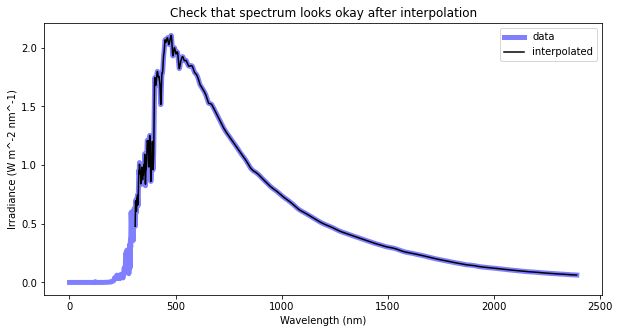

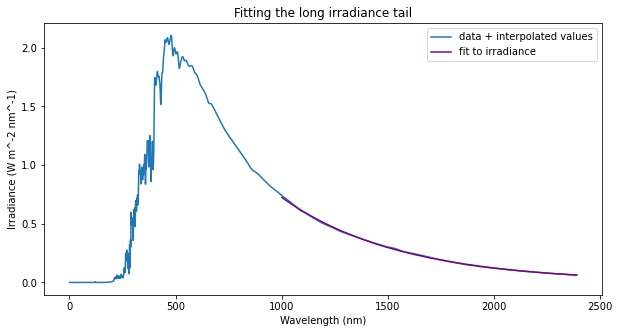

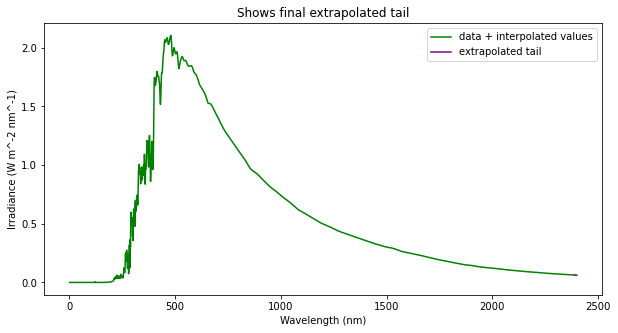

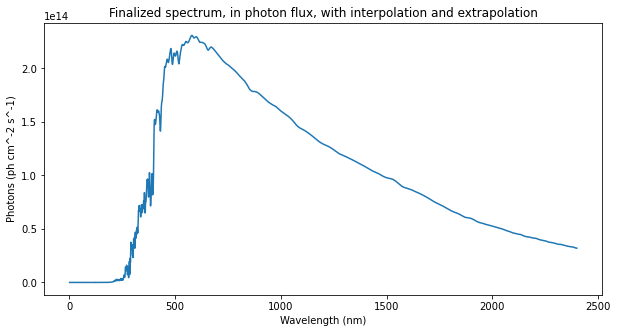

In [58]:
solarmin_2008 = np.loadtxt("../Resources/Solar data/solarmin_20081029_SORCE_and_TIMED.dat", skiprows=1)
solarmin_2008_df = pd.DataFrame(solarmin_2008, columns=["λ (nm)", "irradiance (W/m^2/nm)"])
solarmin_2008_df_tidy = interpolate_solar_spectrum(solarmin_2008_df, 1.524, show_plots=True)
solarmin_2008_df_tidy.to_csv("marssolarphotonflux_solarmin_NEW.dat", sep='\t', columns=["λ (nm)", "photon flux (γ/s/cm^2/nm)"], index=False)

## Solar mean

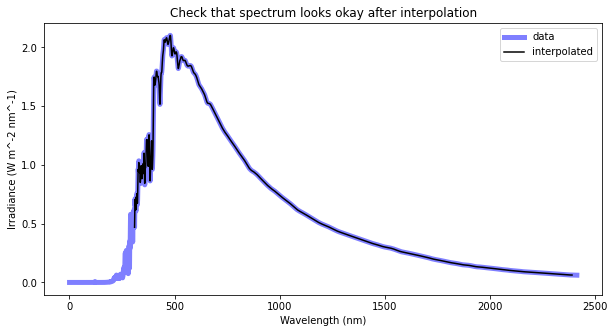

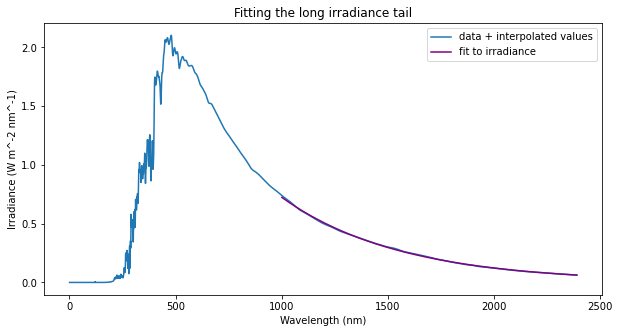

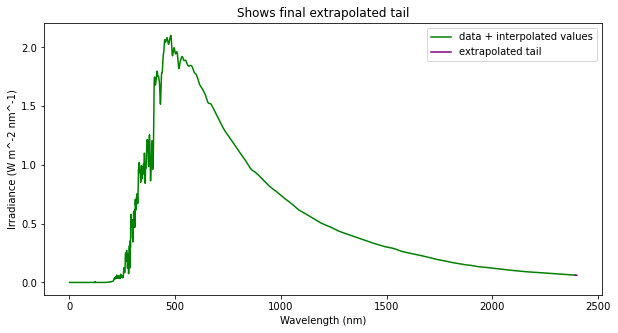

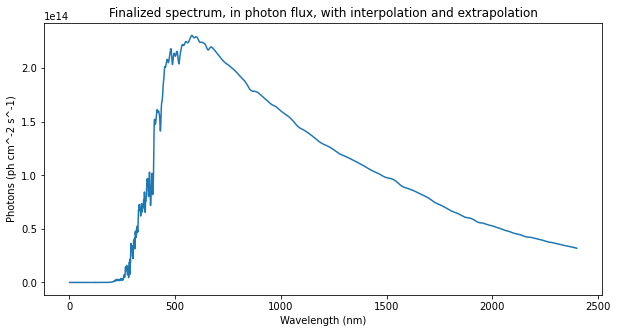

In [13]:
solarmean_2004 = np.loadtxt("../Resources/Solar data/solarmean_2004-02-07_SORCE_and_TIMED.dat", skiprows=2)
solarmean_2004_df = pd.DataFrame(solarmean_2004, columns=["λ (nm)", "irradiance (W/m^2/nm)"])
solarmean_2004_df_tidy = interpolate_solar_spectrum(solarmean_2004_df, 1.524, show_plots=True)
solarmean_2004_df_tidy.to_csv("marssolarphotonflux_solarmean_NEW.dat", sep='\t', columns=["λ (nm)", "photon flux (γ/s/cm^2/nm)"], index=False)

## Solar max

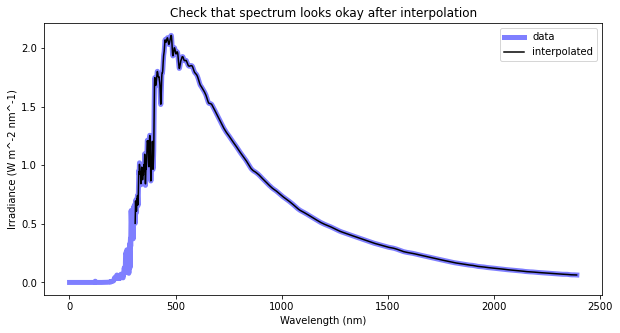

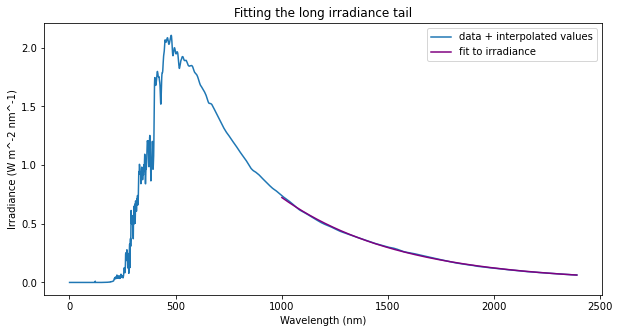

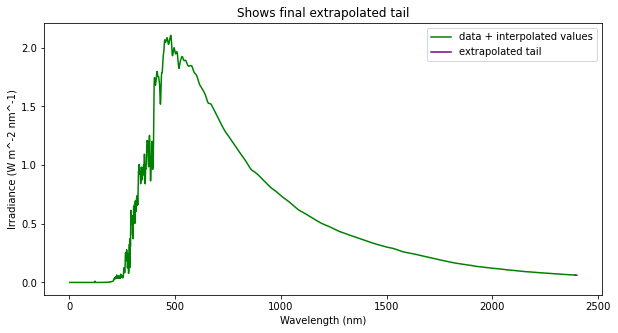

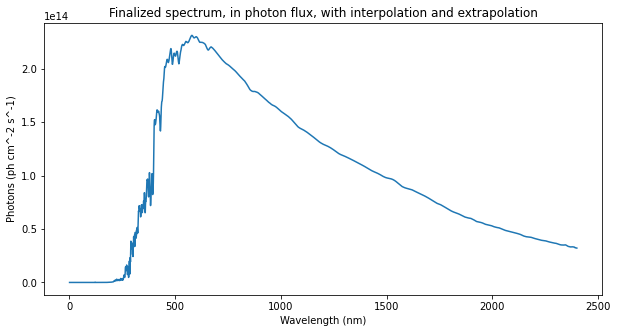

In [6]:
solarmax = np.loadtxt("../Resources/Solar data/solarmax_20150604_and_20020322_SORCE_and_TIMED.dat", skiprows=1)
solarmax_df = pd.DataFrame(solarmax, columns=["λ (nm)", "irradiance (W/m^2/nm)"])
solarmax_df_tidy = interpolate_solar_spectrum(solarmax_df, 1.524, show_plots=True)
solarmax_df_tidy.to_csv("marssolarphotonflux_solarmax_NEW.dat", sep='\t', columns=["λ (nm)", "photon flux (γ/s/cm^2/nm)"], index=False)

# Load data from SORCE and TIMED/SEE

# Scale the solar mean spectrum for both aphelion and perihelion

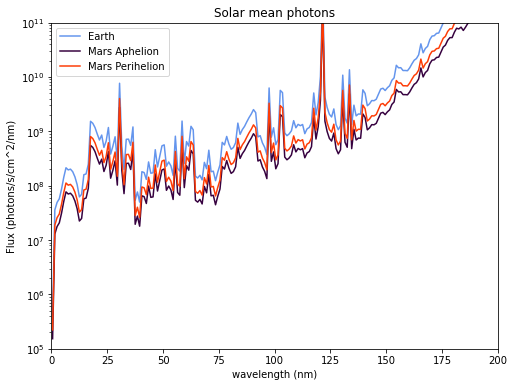

In [14]:
solarmean_df = pd.DataFrame(solarmean_2004, columns=["λ (nm)", "irradiance (W/m^2/nm)"]) # Irradiance is in W/m^2/nm
h = 6.626e-34
c = 3e8

# this is the ratio of the orbital sphere surface areas at Earth (top) and Mars. 
aphelion_sphereratio = 1/(1.6662**2)
perihelion_sphereratio = 1/(1.3814**2) 

m_per_nm = 1e-9

W_per_nm = solarmean_df["irradiance (W/m^2/nm)"]
photon_per_s_nm = W_per_nm / ((h*c)/(solarmean_df["λ (nm)"] * m_per_nm))
photon_per_s_nm_per_cm2 = photon_per_s_nm / 10000

Mars_photon_flux_aphelion = photon_per_s_nm_per_cm2 * aphelion_sphereratio 
Mars_photon_flux_perihelion = photon_per_s_nm_per_cm2 * perihelion_sphereratio

solarmean_df["EarthSpectrum"] = pd.Series(photon_per_s_nm_per_cm2, index=solarmean_df.index)
solarmean_df["AphelionSpectrum"] = pd.Series(Mars_photon_flux_aphelion, index=solarmean_df.index)
solarmean_df["PerihelionSpectrum"] = pd.Series(Mars_photon_flux_perihelion, index=solarmean_df.index)

fig, ax = plt.subplots(figsize=(8,6))
plt.plot(solarmean_df["λ (nm)"], solarmean_df["EarthSpectrum"], color="cornflowerblue", label="Earth")
plt.plot(solarmean_df["λ (nm)"], solarmean_df["AphelionSpectrum"], color="xkcd:deep purple", label="Mars Aphelion")
plt.plot(solarmean_df["λ (nm)"], solarmean_df["PerihelionSpectrum"], color="xkcd:red orange", label="Mars Perihelion")

plt.title("Solar mean photons")
plt.ylabel("Flux (photons/s/cm^2/nm)")
plt.xlabel("wavelength (nm)")
plt.legend()
plt.xlim(0,200)
plt.yscale("log")
plt.ylim(1e5,1e11)
plt.show()

## Process into files

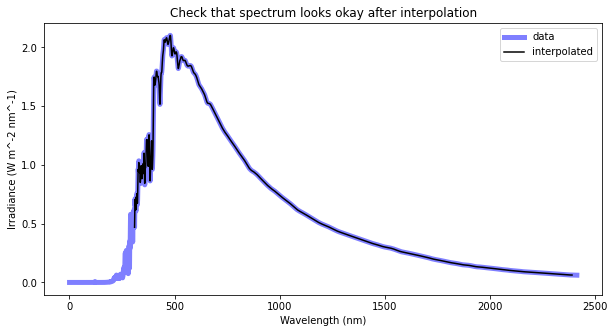

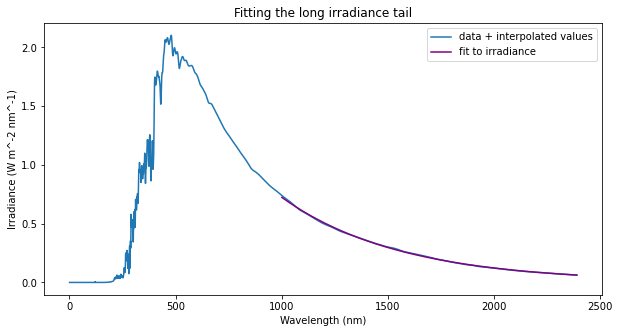

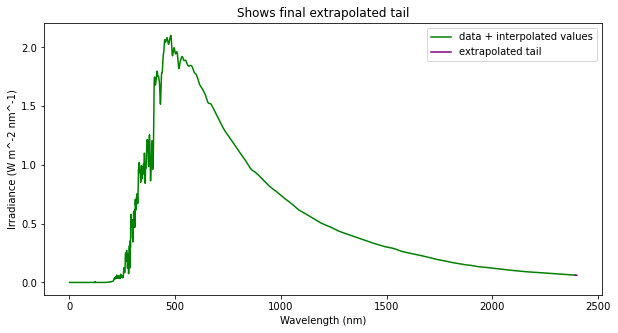

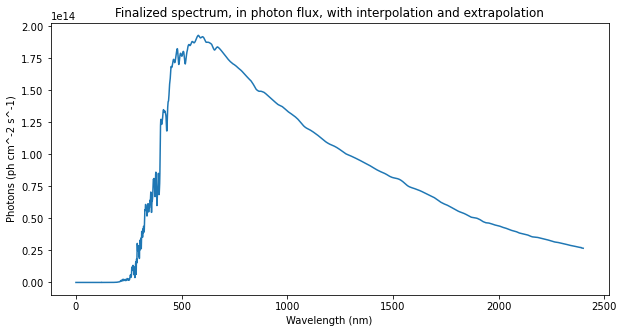

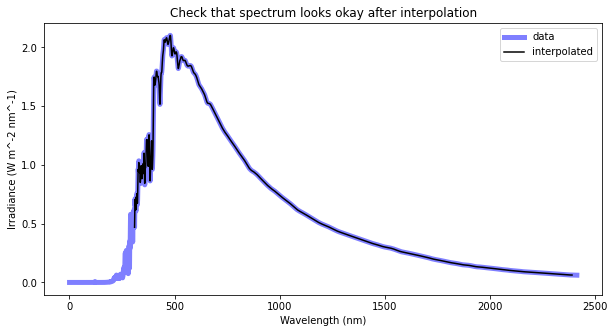

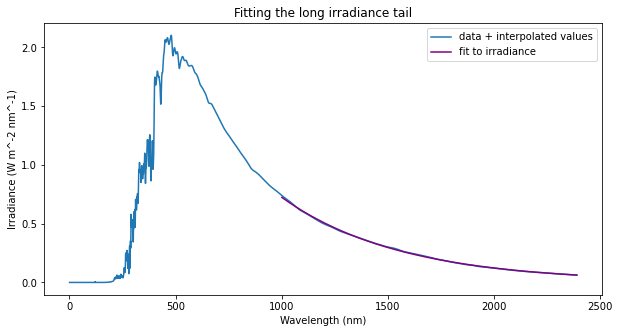

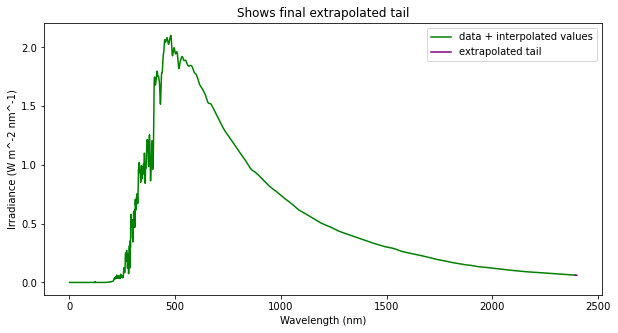

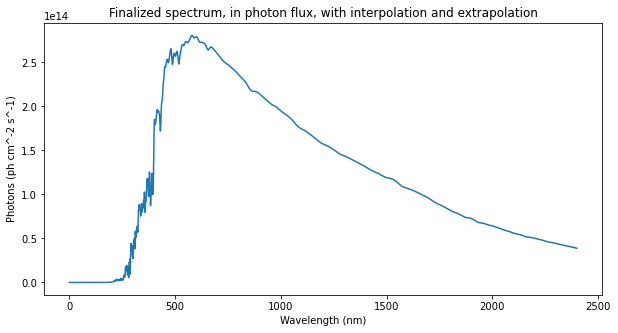

In [15]:
ap_spec = solarmean_aphelion = interpolate_solar_spectrum(solarmean_df, 1.6662, show_plots=True)
peri_spec = solarmean_perihelion = interpolate_solar_spectrum(solarmean_df, 1.3814, show_plots=True)

ap_spec.to_csv("marssolarphotonflux_solarmean_aphelion.dat", sep='\t', columns=["λ (nm)", "photon flux (γ/s/cm^2/nm)"], index=False)
peri_spec.to_csv("marssolarphotonflux_solarmean_perihelion.dat", sep='\t', columns=["λ (nm)", "photon flux (γ/s/cm^2/nm)"], index=False)